In [1]:
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np

import matplotlib.pyplot as plt
# %matplotlib inline
import os

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size

x_train = np.reshape(x_train, [-1, original_dim]) # 60000 * 784
x_test = np.reshape(x_test, [-1, original_dim]) # 10000 * 784
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (original_dim, )

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 10

In [4]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    # we wish to sample from N(mu, var)
    # epsilon ~ N(0, 1)
    # epsilon * var + mu ~ N(mu, var)

    z_mean, z_log_var = args     #  bs,2
    print(z_mean, z_log_var)
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1] # Returns the shape of tensor or variable as a tuple of int or None entries.
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
# VAE model = encoder + decoder
# build encoder model
def encoder_model(inputs):
    x = Dense(intermediate_dim, activation='relu')(inputs) # 784 -> 512 (784*512+512)
    z_mean = Dense(latent_dim, name='z_mean')(x) # 512 -> 2
    z_log_var = Dense(latent_dim, name='z_log_var')(x) # 512 -> 2
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder, z_mean, z_log_var

In [6]:
inputs = Input(shape=input_shape, name='encoder_input')
encoder, z_mean, z_log_var = encoder_model(inputs)
encoder.summary()

Tensor("Placeholder:0", shape=(None, 2), dtype=float32) Tensor("Placeholder_1:0", shape=(None, 2), dtype=float32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 512)                  401920    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['dense[0][0]']               
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['dense[0

In [8]:
def decoder_model():
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs) # 2 -> 512
    outputs = Dense(original_dim, activation='sigmoid')(x)  # 512 -> 784

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

In [9]:
decoder = decoder_model()
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# instantiate VAE model
# test = encoder(inputs)
# z = test[2]
# outputs = decoder(z)
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Tensor("encoder/z_mean/BiasAdd:0", shape=(None, 2), dtype=float32) Tensor("encoder/z_log_var/BiasAdd:0", shape=(None, 2), dtype=float32)


In [11]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               403972    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               403728    
                                                                 
Total params: 807700 (3.08 MB)
Trainable params: 807700 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


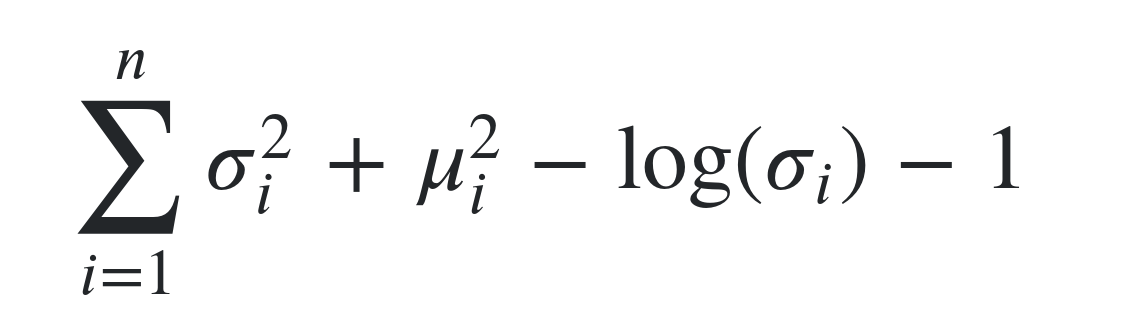

In [12]:
reconstruction_loss = mse(inputs, outputs)     # mean = sum/784
# reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = -1 - 0.5*z_log_var + K.square(z_mean) + K.exp(z_log_var) # bs, 2
kl_loss = K.sum(kl_loss, axis=-1)   # bs
kl_loss *= 0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)   # bs()
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [13]:
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist_latent_dim_%s.h5' %latent_dim)
# vae.load_weights('vae_mlp_mnist_latent_dim_2.h5')

Epoch 1/10
Tensor("vae_mlp/encoder/z_mean/BiasAdd:0", shape=(None, 2), dtype=float32) Tensor("vae_mlp/encoder/z_log_var/BiasAdd:0", shape=(None, 2), dtype=float32)
Tensor("vae_mlp/encoder/z_mean/BiasAdd:0", shape=(None, 2), dtype=float32) Tensor("vae_mlp/encoder/z_log_var/BiasAdd:0", shape=(None, 2), dtype=float32)
469/469 [==============================] - 7s 5ms/step - loss: 50.9559 - val_loss: 42.4732
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 41.4047 - val_loss: 40.5352
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 40.0079 - val_loss: 39.4549
Epoch 4/10
469/469 [==============================] - 3s 5ms/step - loss: 39.1193 - val_loss: 38.7871
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 38.5310 - val_loss: 38.3722
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 38.0808 - val_loss: 38.0534
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 37.7099 

79/79 [==============================] - 0s 3ms/step


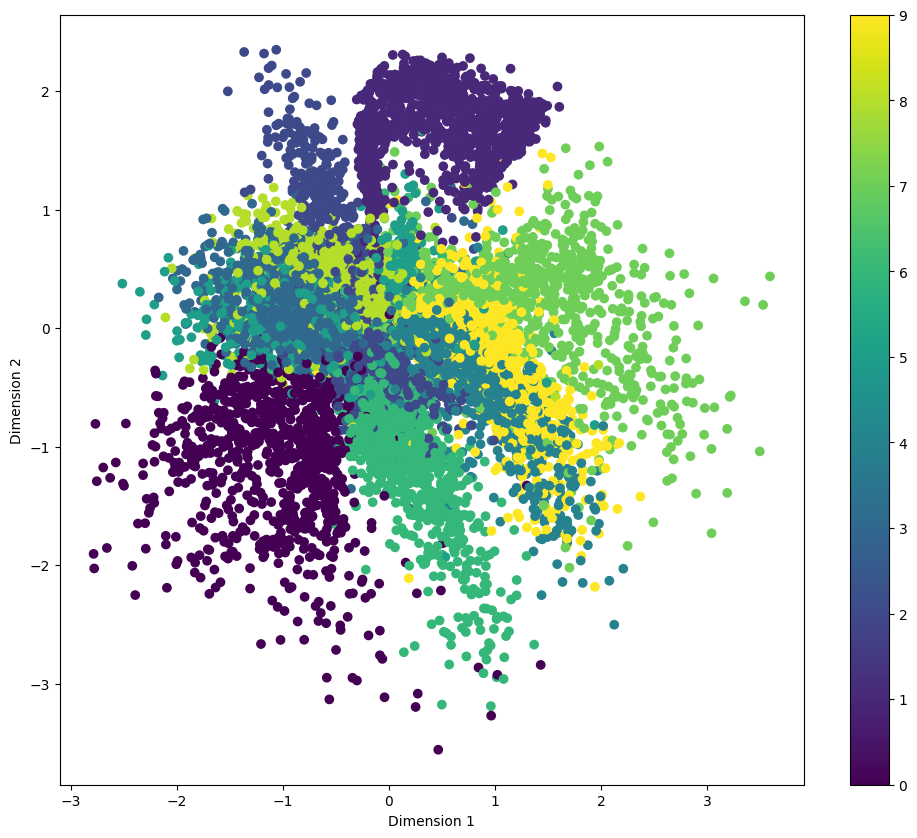

In [ ]:
model_name = 'vae_mnist'
filename = "vae_mean.png"
# display a 2D plot of the digit classes in the latent space
z_mean, _, _ = encoder.predict(x_test,
                               batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig(filename)

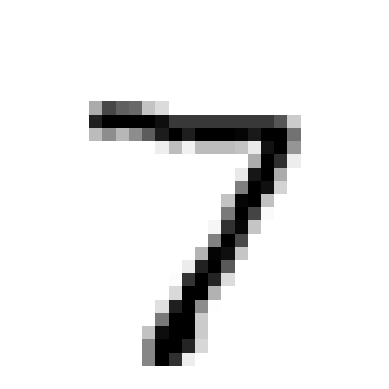

In [14]:
img = np.reshape(x_test[0], (image_size, image_size))
plt.axis('off')
plt.imshow(img, cmap = 'gray_r')
plt.savefig('seven_original.png')

In [15]:
encoder_input = np.expand_dims(x_test[0], axis = 0)

In [16]:
encoder_input.shape, encoder.input_shape

((1, 784), (None, 784))

In [17]:
mean, var, z = encoder.predict(encoder_input)

Tensor("encoder/z_mean/BiasAdd:0", shape=(None, 2), dtype=float32) Tensor("encoder/z_log_var/BiasAdd:0", shape=(None, 2), dtype=float32)
1/1 [==============================] - 0s 111ms/step


In [18]:
decoded_output = decoder.predict(mean)

1/1 [==============================] - 0s 43ms/step


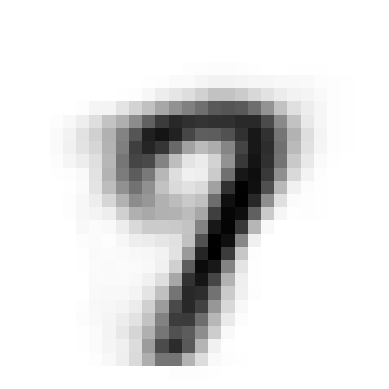

In [19]:
img = np.reshape(x_test[0], (image_size, image_size))
plt.axis('off')
plt.imshow(np.reshape(decoded_output, (image_size, image_size)), cmap = 'gray_r')
plt.savefig('seven_reproduced.png')

1/1 [==============================] - 0s 16ms/step


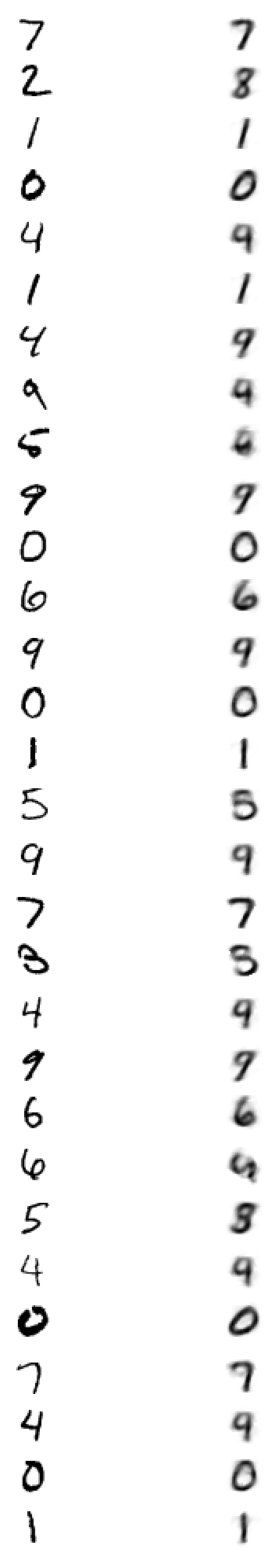

In [ ]:
plt.figure(figsize=(5, 20))
for i in range(30):
    plt.subplot(30, 2, 2*i+1)
    img = np.reshape(x_test[i], (image_size, image_size))
    plt.axis('off')
    plt.imshow(img, cmap = 'gray_r')

    plt.subplot(30, 2, 2*i + 2)
    encoder_input = np.expand_dims(x_test[i], axis = 0)
    mean, var, z = encoder.predict(encoder_input)
    decoded_output = decoder.predict(mean)
    img = np.reshape(x_test[0], (image_size, image_size))
    plt.axis('off')
    plt.imshow(np.reshape(decoded_output, (image_size, image_size)), cmap = 'gray_r')
plt.savefig('mnist_reproduction.png')

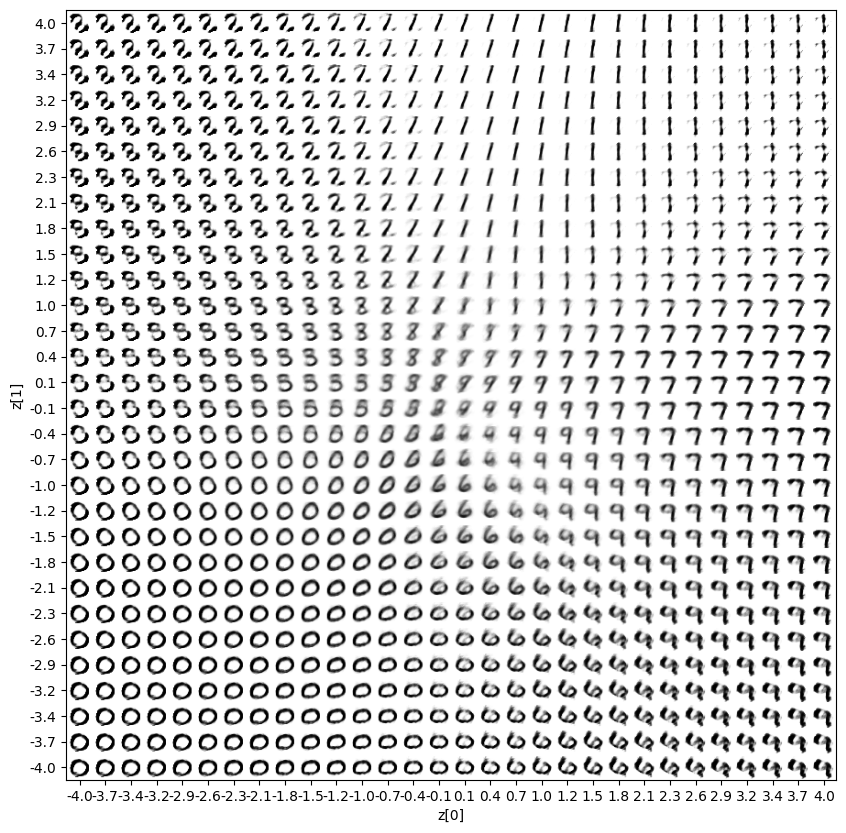

In [ ]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]


for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='gray_r')